# Creating AnyScript Macros

AnyPyTools can help write the AnyScript macros automatically. Doing so make it easier to create complex macros and do things like parameter studies, Monte Carlo simulation, etc.  

Most AnyBody class operations and macros have a correspoding helper class in AnyPyTools. 

In [1]:
from anypytools.macro_commands import (
MacroCommand, 
Load,
Dump,
SetValue,
SetValue_random,
SaveDesign,
LoadDesign, 
SaveValues,
LoadValues,
UpdateValues,
RunOperation,
Export,
ExtendOutput,
)

## A quick example

The following shows how the to generate a simple macro.

In [2]:
macrolist = [
    Load('Knee.any', defs={'SUBJECT':'"S02"', 'TRIAL':'"T04"'}),
    RunOperation('Main.MyStudy.InverseDynamics'),
    Export('Main.MyStudy.Output.MaxMuscleActivity'),
] 
macrolist 

[load "Knee.any" -def SUBJECT=---"\"S02\"" -def TRIAL=---"\"T04\"",
 operation Main.MyStudy.InverseDynamics
 run,
 print Main.MyStudy.Output.MaxMuscleActivity]

Each macro object will generate one or more macro commands with the correct syntax.
The macro can be launched using the `start_macro()` method of  the `AnyPyProcess`  object.


In [3]:
from anypytools import AnyPyProcess
app = AnyPyProcess()
app.start_macro(macrolist);

Output()

Completed: 1


## Overview of macro commands
The `macro_commands` module have classes for generating many of the standard AnyScipt macro commands.

- `Load(mainfile, defines, paths)`: Loads a model file in AnyBody
- `RunOperation(var)`: Runs an operation
- `Export(var, name)`: Exports a variable from AnyBody with a optionally different name. 
- `ExtendOutput(var, value)`: Add an arbitrary `var=value` to the output.
- `LoadDesign(var, filename)`: classoperation "Load design" 
- `SaveDesign(var, filename)`: classoperation "Save design" 
- `LoadValues(filename)`: classoperation Main "Load Values" 
- `SaveValues(filename)`: classoperation Main "Save Values"
- `UpdateValues()`: classoperation "Update Values"
- `SetValue(var,value)`: classoperation "Set Value" 
- `MacroCommand(macro_string)`: Add abitrary macro string

## Creating many macros

The macro in the previous example would have been easy to write manually. However, in some cases we want to create many macros. Then it is a big advantage to generate them programmatically. 

This is easily done in Python with a `for` loop. 

In [4]:
macrolist = []
for i in range(3):
    macro = [
        Load('Knee.any' ),
        RunOperation('Main.MyStudy.InverseDynamics'),
    ]
    macrolist.append(macro)
    
macrolist

[[load "Knee.any",
  operation Main.MyStudy.InverseDynamics
  run],
 [load "Knee.any",
  operation Main.MyStudy.InverseDynamics
  run],
 [load "Knee.any",
  operation Main.MyStudy.InverseDynamics
  run]]

Running many macros is only really useful if the macros are different. So let us try to create a macro which sets different values in each run.  

Imagine a list of 5 parameters. We want to create five macros that use these values:

In [5]:
parameter_list = [2.2, 2.5, 2.7, 2.9, 3.1]

macrolist = []
for val in parameter_list:
    macro = [
        Load('Knee.any' ),
        SetValue('Main.MyParameter', val),
        RunOperation('Main.MyStudy.InverseDynamics'),
    ]
    macrolist.append(macro)
    
macrolist

[[load "Knee.any",
  classoperation Main.MyParameter "Set Value" --value="2.2",
  operation Main.MyStudy.InverseDynamics
  run],
 [load "Knee.any",
  classoperation Main.MyParameter "Set Value" --value="2.5",
  operation Main.MyStudy.InverseDynamics
  run],
 [load "Knee.any",
  classoperation Main.MyParameter "Set Value" --value="2.7",
  operation Main.MyStudy.InverseDynamics
  run],
 [load "Knee.any",
  classoperation Main.MyParameter "Set Value" --value="2.9",
  operation Main.MyStudy.InverseDynamics
  run],
 [load "Knee.any",
  classoperation Main.MyParameter "Set Value" --value="3.1",
  operation Main.MyStudy.InverseDynamics
  run]]

## A simple parameter study

Let us combine the previous to create a parameter study. We will continue with the simplified knee model where we left off in the previous tutorial. The parameter study will vary the patella tendon length from 2.0cm to 8.0cm, and observe the effect on maximum muscle activity.

First we create a list of patella length parameters. 

In [6]:
patella_tendon_lengths = [
    0.02 + i*0.01 
    for i in range(7)
]
print(patella_tendon_lengths)

[0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]


This list of values is added to the macros with the `SetValue` class. 

In [7]:
parameter_study_macro = []

for patella_length in patella_tendon_lengths:
    macro = [
        Load('Knee.any'),
        SetValue('Main.MyModel.PatellaLigament.DriverPos', patella_length),
        RunOperation('Main.MyStudy.InverseDynamics'),
        Export('Main.MyStudy.Output.Abscissa.t', "Time steps"),
        Export('Main.MyStudy.Output.MaxMuscleActivity', "Max muscle activity"),
        ExtendOutput("PatellaLength", patella_length),
    ]
    parameter_study_macro.append(macro)


Note, that here we have used two special helper classes `Export(var, name)`, and `ExtendOutput(name, value)`. The `Export` class allows us to rename the output variables, so we don't need to refer to the long AnyBody names in the output. I.e. `Main.MyStudy.Output.Abscissa.t` becomes `Time steps` in the output.

The second `ExtendOutput` is mostly a convinance, as it adds a `PatellaLength` variable to the output, so we don't need to keep track of which length corresponds to different ouptuts.  

In [8]:
parameter_study_macro[0:2]

[[load "Knee.any",
  classoperation Main.MyModel.PatellaLigament.DriverPos "Set Value" --value="0.02",
  operation Main.MyStudy.InverseDynamics
  run,
  print "#### ANYPYTOOLS RENAME OUTPUT: Time steps"
  print Main.MyStudy.Output.Abscissa.t,
  print "#### ANYPYTOOLS RENAME OUTPUT: Max muscle activity"
  print Main.MyStudy.Output.MaxMuscleActivity,
  print "PatellaLength = 0.02;"],
 [load "Knee.any",
  classoperation Main.MyModel.PatellaLigament.DriverPos "Set Value" --value="0.03",
  operation Main.MyStudy.InverseDynamics
  run,
  print "#### ANYPYTOOLS RENAME OUTPUT: Time steps"
  print Main.MyStudy.Output.Abscissa.t,
  print "#### ANYPYTOOLS RENAME OUTPUT: Max muscle activity"
  print Main.MyStudy.Output.MaxMuscleActivity,
  print "PatellaLength = 0.03;"]]

It means that the macro now starts to look a bit messy. But luckly we don't have think about that.

We just pass the `parameter_study_macro` to the `start_macro()` function which gives us back a `results` variable:

In [9]:
results = app.start_macro(parameter_study_macro)

Output()

Completed: 7


The `results` variable is now a list of with the results from each of the simulations

In [10]:
results[0]

{'Time steps': 
   array([0.        , 0.02424242, 0.04848485, 0.07272727, 0.0969697 ,
          0.12121212, 0.14545455, 0.16969697, 0.19393939, 0.21818182,
          0.24242424, 0.26666667, 0.29090909, 0.31515152, 0.33939394,
          0.36363636, 0.38787879, 0.41212121, 0.43636364, 0.46060606,
          0.48484848, 0.50909091, 0.53333333, 0.55757576, 0.58181818,
          0.60606061, 0.63030303, 0.65454545, 0.67878788, 0.7030303 ,
          0.72727273, 0.75151515, 0.77575758, 0.8       , 0.82424242,
          0.84848485, 0.87272727, 0.8969697 , 0.92121212, 0.94545455,
          0.96969697, 0.99393939, 1.01818182, 1.04242424, 1.06666667,
          1.09090909, 1.11515152, 1.13939394, 1.16363636, 1.18787879,
          1.21212121, 1.23636364, 1.26060606, 1.28484848, 1.30909091,
          1.33333333, 1.35757576, 1.38181818, 1.40606061, 1.43030303,
          1.45454545, 1.47878788, 1.5030303 , 1.52727273, 1.55151515,
          1.57575758, 1.6       , 1.62424242, 1.64848485, 1.67272727,
    

Now we can plot the data, by simply looping over the results. 

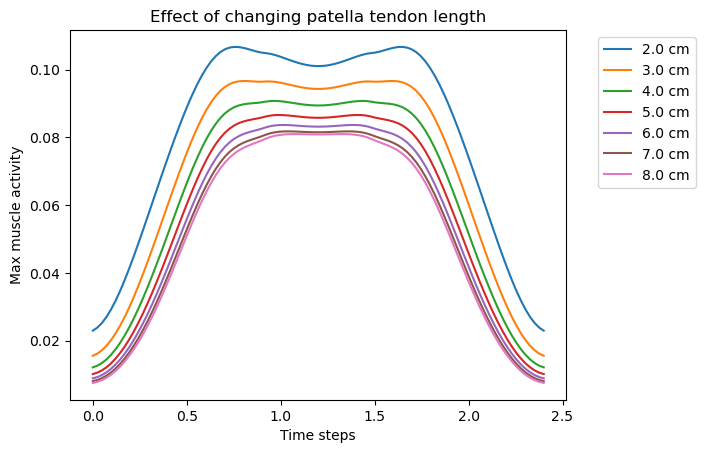

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

for data in results:
    plt.plot(
        data['Time steps'],
        data['Max muscle activity'],
        label=f'{100* data["PatellaLength"]:.1f} cm'
    )

plt.title('Effect of changing patella tendon length')    
plt.xlabel('Time steps')
plt.ylabel('Max muscle activity')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);
